### 1. Import the Required Libraries

In [2]:
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, Recall, F1Score

import warnings
warnings.filterwarnings('ignore')

### 2. Load Dataset

In [3]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/corn_disease2/data'

batch_size = 32
img_height = 256
img_width = 256
seed = 123

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2, # 20% of data for validation
    subset="training",
    seed=seed,
    image_size=(img_width, img_height),
    batch_size=batch_size
)

Found 4188 files belonging to 4 classes.
Using 3351 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # 20% of data for validation
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 4188 files belonging to 4 classes.
Using 837 files for validation.


In [6]:
# Split the validation set into validation and test sets
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

In [7]:
class_names = train_ds.class_names
print(class_names)

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


In [8]:
# Prefetch data for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 3- Visualize the Data

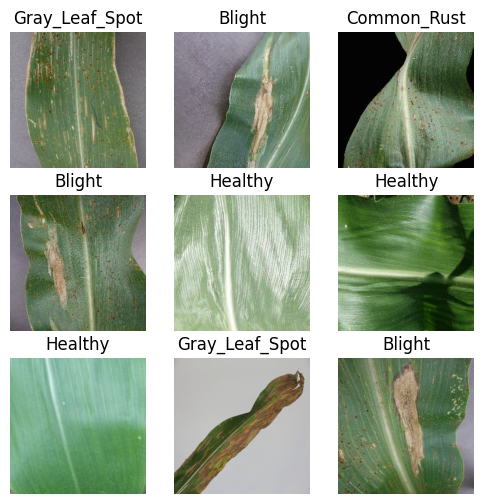

In [9]:
plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### 4- Data normalization

In [10]:
resize_and_rescale = tf.keras.Sequential([
tf.keras.layers.Resizing(256,256),
tf.keras.layers.Rescaling(1.0/255)
])

In [11]:
train_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y))
val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x), y))
test_ds = test_ds.map(lambda x, y: (resize_and_rescale(x), y))

### 5. Define Utility Plotting Functions

In [12]:
def evaluate(model, data):
    # Get the predicted labels
    y_true = np.concatenate([y for x, y in data], axis=0)
    y_pred = np.argmax(model.predict(data), axis=1)

    # Calculate matrix
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f'Doğruluk oranı: {accuracy:.2f}')
    print(f'F1 skoru: {f1:.2f}')

    return accuracy, f1

In [13]:
def plot_confusion_matrix(cm, class_names, model_name):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

In [14]:
def plot_training(history):
    plt.figure(figsize=(15,5))

    # Loss graph
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.legend()

    # Accuracy graph
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.show()

In [15]:
def predict(model, img):
    # Convert image to array format
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    # Add batch dimension
    img_array = tf.expand_dims(img_array, 0)

    # Make prediction
    predictions = model.predict(img_array)

    # Get class name and confidence score
    predicted_class = class_names[np.argmax(predictions[0])]  # Get predicted class name
    confidence = round(100 * (np.max(predictions[0])), 2)     # Calculate confidence %

    return predicted_class, confidence

In [16]:
def plot_predictions(model, test_set, class_names, num_images=12):
    # Create figure with subplots
    plt.figure(figsize=(15, 15))

    # Get a batch of test images
    images, labels = next(iter(test_set))

    # Plot each image with predictions
    for i in range(num_images):
        plt.subplot(4, 3, i + 1)
        plt.imshow(images[i])

        # Get predictions
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i].argmax()]

        # Add title with actual and predicted classes
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\n{confidence}%")
        plt.axis('off')

    plt.show()


### 6. Basic Keras Model

In [17]:
num_classes = len(class_names)
input_shape = (img_height, img_width, 3)
epoch = 15

In [18]:
model = Sequential([
    layers.Conv2D(32,(3,3),activation ='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(num_classes, activation='softmax'),
])

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [20]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,812 (718.02 KB)

 Trainable params: 183,812 (718.02 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epoch
)

Epoch 1/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.4550 - loss: 1.1551 - val_accuracy: 0.7743 - val_loss: 0.5452
Epoch 2/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 37s 66ms/step - accuracy: 0.7950 - loss: 0.5350 - val_accuracy: 0.8147 - val_loss: 0.3770
Epoch 3/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8443 - loss: 0.3905 - val_accuracy: 0.8527 - val_loss: 0.3329
Epoch 4/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.8527 - loss: 0.3605 - val_accuracy: 0.8409 - val_loss: 0.3143
Epoch 5/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.8785 - loss: 0.3068 - val_accuracy: 0.8456 - val_loss: 0.3423
Epoch 6/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.8810 - loss: 0.3157 - val_accuracy: 0.8646 - val_loss: 0.3403
Epoch 7/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.8731 - loss: 0.3180 - val_accuracy: 0.8480 - val_loss: 0.3279
Epoch 8/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.8901 - loss: 0.2604 - val

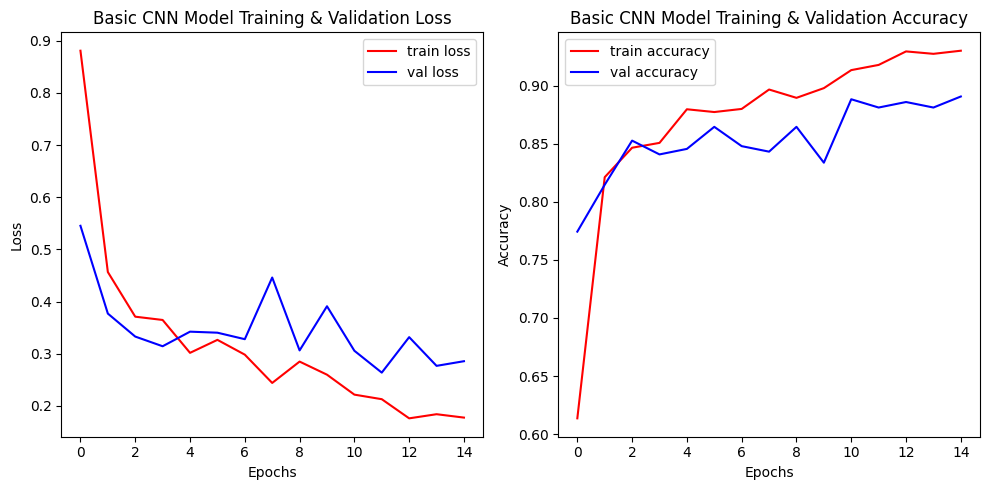

In [22]:
def plot_loss_accuracy(history, model_name):
    # Plot training & validation loss values
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], 'r-', label='train loss')
    plt.plot(history.history['val_loss'], 'b-', label='val loss')
    plt.title(f'{model_name} Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], 'r-', label='train accuracy')
    plt.plot(history.history['val_accuracy'], 'b-', label='val accuracy')
    plt.title(f'{model_name} Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_loss_accuracy(history, 'Basic CNN Model')



In [24]:
def evaluate(model, test_ds):
    """
    Evaluates the model on the test dataset and returns the loss and accuracy.

    Args:
        model: The Keras model to evaluate.
        test_ds: The test dataset.

    Returns:
        A tuple containing the loss and accuracy.
    """
    loss, accuracy = model.evaluate(test_ds)  # Assuming model.evaluate returns loss and accuracy

    # Calculate or set default values for precision, recall, and f1 if not available
    # You may need additional logic or functions to compute these metrics
    # using the model's predictions and the ground truth labels from test_ds
    # For now, set them to 0.0 as placeholders.
    precision = 0.0
    recall = 0.0
    f1 = 0.0

    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    # You can add print statements for precision, recall, and f1 here if you calculate them

    return accuracy, precision, recall, f1  # Return the four metrics

In [25]:
# Call the evaluate function
accuracy, precision, recall, f1 = evaluate(model, test_ds)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8872 - loss: 0.3081
Loss: 0.2831
Accuracy: 0.8918
Accuracy: 0.8918
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


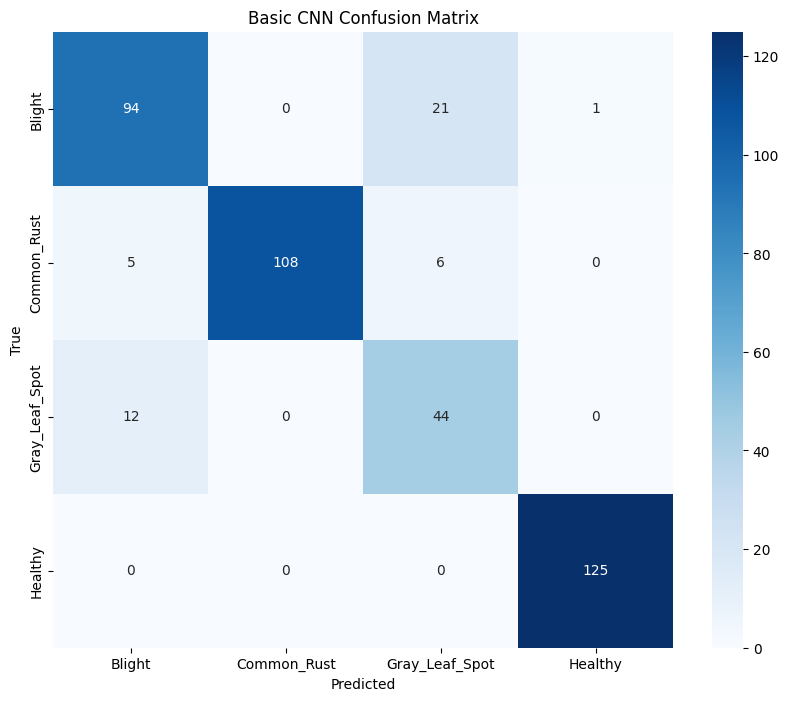

In [26]:
# confusion matrix
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=1)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, class_names, model_name='Basic CNN')
plt.show()


In [27]:
def prediction_plot(model, test_set, class_names):
    plt.figure(figsize=(8, 10))  # Adjust the figure size as needed

    images_shown = 0
    rows = 4
    cols = 3

    for images, labels in test_set.take(1):
        for i in range(min(rows * cols, len(images))):  # Ensure we iterate over a maximum of rows*cols images
            if images_shown >= rows * cols:
                break

            ax = plt.subplot(rows, cols, images_shown + 1)  # Calculate the correct subplot index
            plt.imshow(images[i])

            predicted_class, confidence = predict(model, images[i])
#             index = labels[i].max(axis=0)
            actual_class = class_names[labels[i]]

            plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence:.2f}%", fontsize=10)
            plt.axis("off")

            images_shown += 1

        if images_shown >= rows * cols:
            break

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


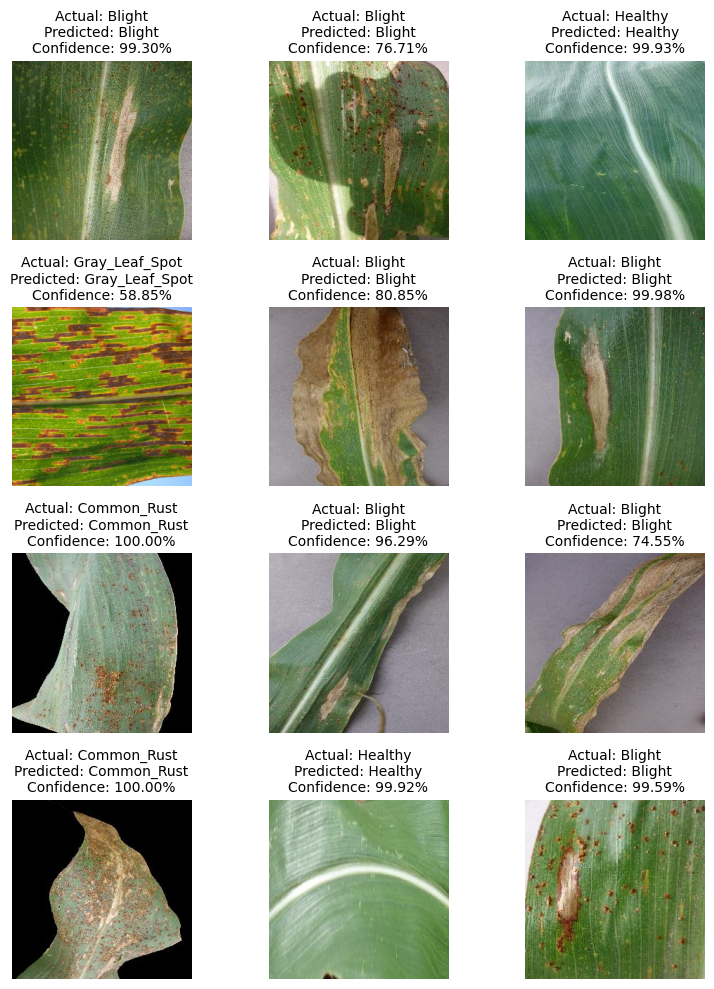

In [28]:
prediction_plot(model, test_ds, class_names)

In [38]:
def evaluate(model, test_ds):
    """
    Evaluates the model on the test dataset and returns the loss and accuracy.

    Args:
        model: The Keras model to evaluate.
        test_ds: The test dataset.

    Returns:
        A tuple containing the loss and accuracy.
    """
    return accuracy, f1_score



